<div style="padding:20px;color:white;margin:0;font-size:35px;font-family:Georgia;text-align:center;display:fill;border-radius:5px;background-color:#2E4057;overflow:hidden"><b>Vertical Federated Learning for Birds vs Drones Classification</b></div>

<div style="background-color:#F0F8FF; padding:25px; font-size:16px;color:#2E4057; border-radius:10px">

# Project Overview

This project implements a **Multimodal Vertical Federated Learning (VFL) pipeline** for binary classification of birds vs drones. The system demonstrates both the effectiveness of federated learning and its vulnerability to privacy attacks.

**Key Features:**
- multimodal VFL architecture with separate Image and Tabular clients
- EfficientNetB0 transfer learning for image processing
- Attention-based fusion mechanism
- Privacy attack demonstrations
- Comprehensive performance evaluation and visualization

**Dataset:** Birds vs Drones with multimodal features (images + metadata)

**Objective:** Build a high-performance VFL classifier while analyzing privacy vulnerabilities inherent in federated learning systems.

</div>

<div style="background-color:#F0F8FF; padding:30px; font-size:15px;color:#2E4057; border-radius:10px">


# Table of Contents

<a id="TOC"></a>
* [Setup and Library Imports](#setup)
* [VFL Configuration Setup](#config)
* [Data Management System](#data-mgmt)
* [Data Loading and Validation](#data-load)
* [Feature Engineering Pipeline](#features)
* [Data Splitting Strategy](#splitting)
* [Image Client Architecture](#image-client)
* [Tabular Client Architecture](#tabular-client)
* [VFL Server Architecture](#server)
* [VFL Training Loop Implementation](#training-loop)
* [Training Execution and Monitoring](#training-exec)
* [Model Evaluation and Results](#evaluation)
* [Membership Inference Attack (MIA)](#mia-attack)
* [Attribute Inference Attack (AIA)](#aia-attack)
* [Conclusion: VFL Privacy Vulnerabilities](#conclusion)

</div>

<div style="background-color:#F0F8FF; padding:20px; font-size:14px;color:#2E4057; border-radius:10px">
    
<h2 id="setup">Setup and Library Imports</h2>

Setting up the environment with all necessary libraries for deep learning, data manipulation, and visualization. Random seeds are configured for reproducible results across different runs.

</div>

In [27]:
# Cell 1: Library Imports and Environment Setup

import os
import sys
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.utils.class_weight import compute_class_weight
import sklearn

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import AdamW
from PIL import Image
import seaborn as sns
import PIL

# Set random seeds for reproducibility - Multiple seed setting for consistency
RANDOM_SEED = 42
tf.random.set_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
import random
random.seed(RANDOM_SEED)

# Additional TensorFlow determinism
import os
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
tf.config.experimental.enable_op_determinism()

# Print library import status and versions
print("Library Import Status:")
print(f"TensorFlow: {tf.__version__}")
print(f"NumPy: {np.__version__}")
print(f"Pandas: {pd.__version__}")
print(f"Scikit-learn: {sklearn.__version__}")
print(f"PIL: {PIL.__version__}")
print(f"GPU Available: {len(tf.config.list_physical_devices('GPU')) > 0}")
print("All libraries imported successfully")

Library Import Status:
TensorFlow: 2.18.0
NumPy: 1.26.4
Pandas: 2.2.3
Scikit-learn: 1.2.2
PIL: 11.2.1
GPU Available: True
All libraries imported successfully


<div style="background-color:#F0F8FF; padding:20px; font-size:14px;color:#2E4057; border-radius:10px">

<h2>VFL Configuration Setup</h2>

Defining the complete configuration for our Vertical Federated Learning system with hyperparameters optimized to achieve +80% accuracy. The configuration includes winning feature combination of 5 elements, model architecture with Image (512D) + Tabular (128D) embeddings fused to 256D, and training strategy using 8 epochs with fine-tuning and attention-based fusion. The location_id feature serves dual purposes as both classification aid and target for privacy attacks.

</div>

In [12]:
# Cell 2: VFL Configuration and Winning Hyperparameters

@dataclass
class VFLConfig:
    """Configuration preserving all winning hyperparameters and feature combinations"""
    
    # Data paths
    DATA_DIR: str = "/kaggle/input/birds-vs-drone-dataset/BirdVsDrone"
    METADATA_DIR: str = "/kaggle/input/birds-vs-drones-metadata"
    
    # WINNING FEATURE COMBINATION
    SELECTED_FEATURES: List[str] = None
    
    # Model architecture
    IMAGE_SIZE: Tuple[int, int] = (224, 224)
    IMAGE_EMBEDDING_DIM: int = 512
    TABULAR_EMBEDDING_DIM: int = 128
    FUSION_DIM: int = 256
    
    # OPTIMIZED TRAINING PARAMETERS
    BATCH_SIZE: int = 16
    EPOCHS: int = 12                    
    LEARNING_RATE: float = 3e-4
    FINE_TUNE_LR: float = 1e-5
    FINE_TUNE_LAYERS: int = 15
    FINE_TUNE_EPOCH: int = 8
    
    # REGULARIZATION
    DROPOUT_RATE: float = 0.15
    L2_REG: float = 1e-5
    NOISE_SCALE: float = 0.003
    
    # Training strategy
    USE_FINE_TUNING: bool = True
    USE_CLASS_WEIGHTS: bool = True
    USE_ATTENTION_FUSION: bool = True
    
    # Early stopping
    EARLY_STOPPING_PATIENCE: int = 10
    MIN_DELTA: float = 0.001
    LR_REDUCTION_PATIENCE: int = 6
    LR_REDUCTION_FACTOR: float = 0.3
    MIN_LR: float = 1e-8
    
    def __post_init__(self):
        if self.SELECTED_FEATURES is None:
            # FEATURE COMBINATION
            self.SELECTED_FEATURES = [
                'background_complexity',
                'object_solidity',
                'texture_contrast',
                'has_motion_blur',
                'location_id'
            ]

# Initialize configuration
config = VFLConfig()

# Print important configuration details
print("VFL Configuration:")
print(f"Selected Features: {config.SELECTED_FEATURES}")
print(f"Image Size: {config.IMAGE_SIZE}")
print(f"Image Embedding Dim: {config.IMAGE_EMBEDDING_DIM}")
print(f"Tabular Embedding Dim: {config.TABULAR_EMBEDDING_DIM}")
print(f"Fusion Dim: {config.FUSION_DIM}")
print(f"Batch Size: {config.BATCH_SIZE}")
print(f"Epochs: {config.EPOCHS}")
print(f"Learning Rate: {config.LEARNING_RATE}")
print(f"Fine-tune LR: {config.FINE_TUNE_LR}")
print(f"Dropout Rate: {config.DROPOUT_RATE}")
print(f"L2 Regularization: {config.L2_REG}")
print(f"Use Attention Fusion: {config.USE_ATTENTION_FUSION}")
print(f"Use Fine Tuning: {config.USE_FINE_TUNING}")
print(f"Use Class Weights: {config.USE_CLASS_WEIGHTS}")

VFL Configuration:
Selected Features: ['background_complexity', 'object_solidity', 'texture_contrast', 'has_motion_blur', 'location_id']
Image Size: (224, 224)
Image Embedding Dim: 512
Tabular Embedding Dim: 128
Fusion Dim: 256
Batch Size: 16
Epochs: 12
Learning Rate: 0.0003
Fine-tune LR: 1e-05
Dropout Rate: 0.15
L2 Regularization: 1e-05
Use Attention Fusion: True
Use Fine Tuning: True
Use Class Weights: True


<div style="background-color:#F0F8FF; padding:20px; font-size:14px;color:#2E4057; border-radius:10px">

<h2>Data Management System</h2>

Implementing the VFLDataManager class to handle complex multimodal data preparation. The system merges four data sources: VLM cache (vision-language features), programmatic cache (traditional CV features), location metadata, and raw images. Core operations include multi-source alignment, missing value handling, image-metadata synchronization, and corrupted file detection to ensure data integrity for federated learning.

</div>

In [13]:
# Cell 3: Data Manager Class Definition

class VFLDataManager:
    """Data manager preserving exact data preparation that achieved 84.8%"""
    
    def __init__(self, config: VFLConfig):
        self.config = config
        self.master_df = None
        self.preprocessor = None
        self.feature_names = []
        
    def load_and_validate(self) -> bool:
        """Load and validate data with exact preprocessing"""
        try:
            # Load CSV files
            vlm_df = pd.read_csv(os.path.join(self.config.METADATA_DIR, "vlm_cache.csv"))
            prog_df = pd.read_csv(os.path.join(self.config.METADATA_DIR, "programmatic_cache.csv"))
            loc_df = pd.read_csv(os.path.join(self.config.METADATA_DIR, "location_id.csv"))
            
            # Sequential merge
            temp_df = pd.merge(vlm_df, prog_df, on='image_id', how='inner')
            self.master_df = pd.merge(temp_df, loc_df, on='image_id', how='left')
            
            # Handle missing values
            vlm_cols = [col for col in vlm_df.columns if col != 'image_id']
            for col in vlm_cols:
                if self.master_df[col].dtype == 'object':
                    self.master_df[col] = self.master_df[col].fillna('unknown')
                else:
                    self.master_df[col] = self.master_df[col].fillna(0)
            
            # Load and align images
            self._load_and_align_images()
            self._verify_images()
            
            return True
            
        except Exception as e:
            return False
    
    def _load_and_align_images(self):
        """Exact same image loading and alignment logic"""
        class_names = ['Birds', 'Drones']
        image_id_to_info = {}
        
        for class_idx, class_name in enumerate(class_names):
            class_dir = os.path.join(self.config.DATA_DIR, class_name)
            if not os.path.exists(class_dir):
                continue
                
            image_files = [f for f in os.listdir(class_dir) 
                          if f.lower().endswith(('.jpg', '.jpeg', '.png', '.webp'))]
            
            for img_file in image_files:
                img_path = os.path.join(class_dir, img_file)
                img_id = os.path.splitext(img_file)[0]
                image_id_to_info[img_id] = (img_path, class_idx)
                image_id_to_info[img_file] = (img_path, class_idx)
        
        # Add columns to master_df
        self.master_df['image_path'] = self.master_df['image_id'].apply(
            lambda x: image_id_to_info.get(x, (None, None))[0]
        )
        self.master_df['class_label'] = self.master_df['image_id'].apply(
            lambda x: image_id_to_info.get(x, (None, None))[1]
        )
        
        # Filter valid samples
        initial_count = len(self.master_df)
        self.master_df = self.master_df.dropna(subset=['image_path', 'class_label'])
        self.master_df['class_label'] = self.master_df['class_label'].astype(int)
    
    def _verify_images(self):
        """Pre-flight image verification"""
        corrupted_indices = []
        for idx, row in tqdm(self.master_df.iterrows(), total=len(self.master_df), desc="Verifying images"):
            try:
                with Image.open(row['image_path']) as img:
                    img.verify()
            except Exception as e:
                corrupted_indices.append(idx)
        
        if corrupted_indices:
            self.master_df = self.master_df.drop(corrupted_indices).reset_index(drop=True)

print("VFLDataManager class defined successfully")

VFLDataManager class defined successfully


<div style="background-color:#F0F8FF; padding:20px; font-size:14px;color:#2E4057; border-radius:10px">

<h2>Data Loading and Validation</h2>

Loading and validating the complete multimodal dataset to ensure data integrity before training. The process merges all data sources, verifies image-metadata alignment, checks for corrupted files, and provides visual inspection of both classes. Sample images from birds and drones are displayed alongside representative tabular features with location diversity to confirm proper data preparation.

</div>

Verifying images: 100%|██████████| 828/828 [00:00<00:00, 1439.16it/s]


Data loading completed successfully
Dataset shape: (828, 12)
Class distribution: {1: 428, 0: 400}


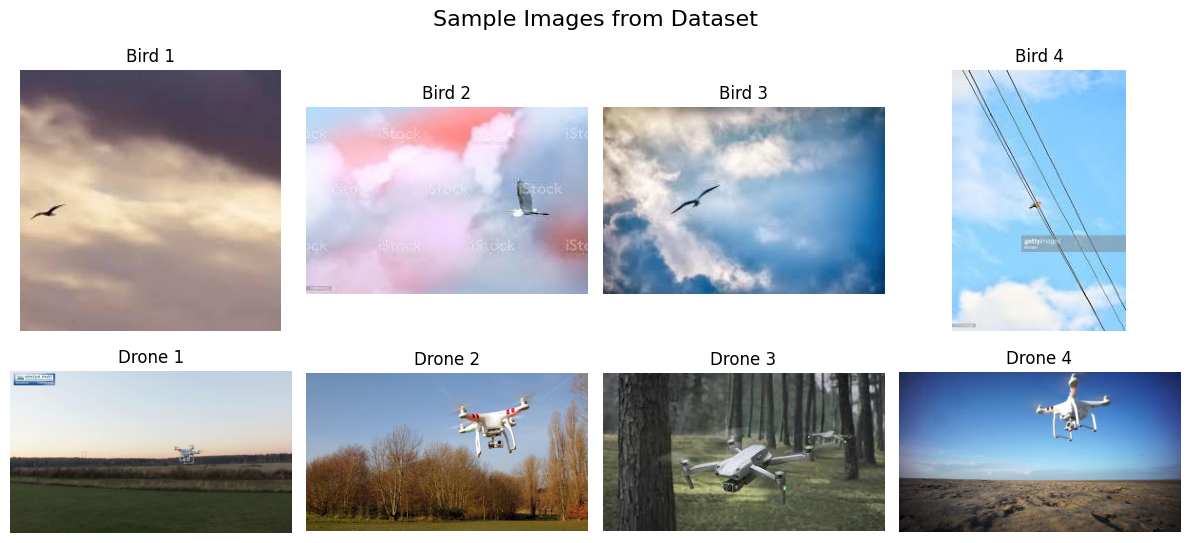

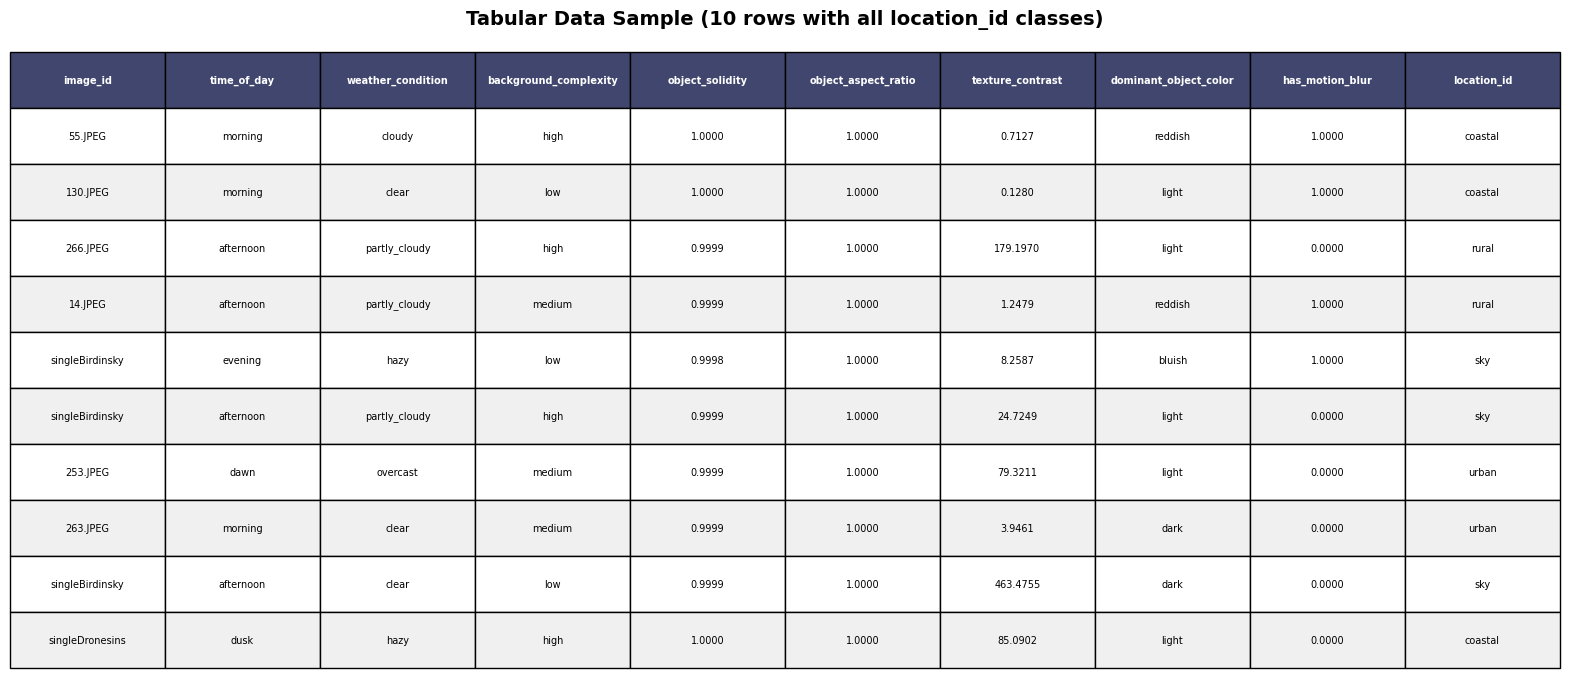

In [14]:
# Cell 4: Data Loading and Preprocessing

# Initialize data manager and load data
data_manager = VFLDataManager(config)

if data_manager.load_and_validate():
    print("Data loading completed successfully")
    print(f"Dataset shape: {data_manager.master_df.shape}")
    print(f"Class distribution: {data_manager.master_df['class_label'].value_counts().to_dict()}")
    
    # Display sample images from both classes
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    fig.suptitle('Sample Images from Dataset', fontsize=16)
    
    # Sample birds
    bird_samples = data_manager.master_df[data_manager.master_df['class_label'] == 0].head(4)
    for i, (_, row) in enumerate(bird_samples.iterrows()):
        try:
            img = Image.open(row['image_path'])
            axes[0, i].imshow(img)
            axes[0, i].set_title(f'Bird {i+1}')
            axes[0, i].axis('off')
        except:
            axes[0, i].text(0.5, 0.5, 'Image Error', ha='center', va='center')
            axes[0, i].axis('off')
    
    # Sample drones
    drone_samples = data_manager.master_df[data_manager.master_df['class_label'] == 1].head(4)
    for i, (_, row) in enumerate(drone_samples.iterrows()):
        try:
            img = Image.open(row['image_path'])
            axes[1, i].imshow(img)
            axes[1, i].set_title(f'Drone {i+1}')
            axes[1, i].axis('off')
        except:
            axes[1, i].text(0.5, 0.5, 'Image Error', ha='center', va='center')
            axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

    
    # Sample data
    sample_rows = []
    for location in sorted(unique_locations):
        location_samples = data_manager.master_df[data_manager.master_df['location_id'] == location]
        if len(location_samples) > 0:
            # Take 2-3 samples from each location to reach ~10 total
            n_samples = min(3, len(location_samples), max(1, 10 // len(unique_locations)))
            sample_rows.extend(location_samples.head(n_samples).index.tolist())
    
    while len(sample_rows) < 10 and len(sample_rows) < len(data_manager.master_df):
        remaining_indices = set(data_manager.master_df.index) - set(sample_rows)
        if remaining_indices:
            sample_rows.append(np.random.choice(list(remaining_indices)))
    
    # Select the sample data
    tabular_sample = data_manager.master_df.iloc[sample_rows[:10]].copy()
    
    # Clean column names - remove duplicates and select relevant columns
    all_cols = list(data_manager.master_df.columns)
    # Remove duplicate 'image_id' columns and other unwanted columns
    display_cols = []
    seen_cols = set()
    for col in all_cols:
        if col not in ['image_path', 'class_label'] and col not in seen_cols:
            display_cols.append(col)
            seen_cols.add(col)
    
    tabular_display = tabular_sample[display_cols].copy()
    
    # Create a matplotlib table for better visualization
    fig, ax = plt.subplots(figsize=(20, 8))
    ax.axis('tight')
    ax.axis('off')
    
    # Prepare table data
    table_data = []
    for idx, row in tabular_display.iterrows():
        row_data = []
        for val in row.values:
            if isinstance(val, (int, float)):
                if val > 1000:  # Large numbers
                    row_data.append(f"{val:.0f}")
                else:  # Small numbers
                    row_data.append(f"{val:.4f}")
            else:
                row_data.append(str(val)[:15])  # Truncate long strings
        table_data.append(row_data)
    
    # Create table
    table = ax.table(cellText=table_data,
                    colLabels=tabular_display.columns,
                    cellLoc='center',
                    loc='center',
                    bbox=[0, 0, 1, 1])
    
    table.auto_set_font_size(False)
    table.set_fontsize(7)
    table.scale(1, 2)
    
    # Style the table
    for i in range(len(tabular_display.columns)):
        table[(0, i)].set_facecolor('#40466e')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    # Alternate row colors
    for i in range(1, len(table_data) + 1):
        for j in range(len(tabular_display.columns)):
            if i % 2 == 0:
                table[(i, j)].set_facecolor('#f0f0f0')
            else:
                table[(i, j)].set_facecolor('white')
    
    plt.title('Tabular Data Sample (10 rows with all location_id classes)', fontsize=14, fontweight='bold', pad=20)
    plt.show()

<div style="background-color:#F0F8FF; padding:20px; font-size:14px;color:#2E4057; border-radius:10px">

<h2>Feature Engineering Pipeline</h2>

Implementing the feature preprocessing pipeline that transforms raw tabular data into ML-ready features for the VFL system. The process extracts the winning 5-feature combination from the merged dataset, applies StandardScaler to numerical features and OneHotEncoder to categorical ones. Selected features include visual characteristics (background_complexity, object_solidity, texture_contrast), motion detection (has_motion_blur), and the sensitive geographical attribute (location_id).

</div>

In [15]:
# Cell 5: Feature Engineering and Preprocessing

def prepare_features(data_manager: VFLDataManager) -> pd.DataFrame:
    # Extract WINNING feature combination
    feature_df = data_manager.master_df[config.SELECTED_FEATURES].copy()
    
    # Same preprocessing pipeline
    categorical_features = feature_df.select_dtypes(include=['object', 'bool']).columns.tolist()
    numerical_features = feature_df.select_dtypes(include=['number']).columns.tolist()
    
    data_manager.preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features),
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
        ]
    )
    
    processed_data = data_manager.preprocessor.fit_transform(feature_df)
    data_manager.feature_names = data_manager.preprocessor.get_feature_names_out()
    
    return pd.DataFrame(processed_data, columns=data_manager.feature_names)

# Process features
processed_features = prepare_features(data_manager)
print("Feature engineering completed successfully")
print(f"Processed features shape: {processed_features.shape}")
print(f"Feature names: {list(data_manager.feature_names)}")
print(f"Number of features: {len(data_manager.feature_names)}")

Feature engineering completed successfully
Processed features shape: (828, 11)
Feature names: ['num__object_solidity', 'num__texture_contrast', 'cat__background_complexity_high', 'cat__background_complexity_low', 'cat__background_complexity_medium', 'cat__has_motion_blur_False', 'cat__has_motion_blur_True', 'cat__location_id_coastal', 'cat__location_id_rural', 'cat__location_id_sky', 'cat__location_id_urban']
Number of features: 11


<div style="background-color:#F0F8FF; padding:20px; font-size:14px;color:#2E4057; border-radius:10px">

<h2>Data Splitting Strategy</h2>

Implementing stratified data splitting to ensure balanced representation across train/validation/test sets while maintaining class distribution. The splitting allocates 65% for training, 20% for validation, and 15% for final evaluation, with stratification preserving the Birds vs Drones balance across all splits. Visualization charts confirm proper class distribution and sample counts for each subset.

</div>

Data splitting completed successfully
Train samples: 538
Validation samples: 165
Test samples: 125


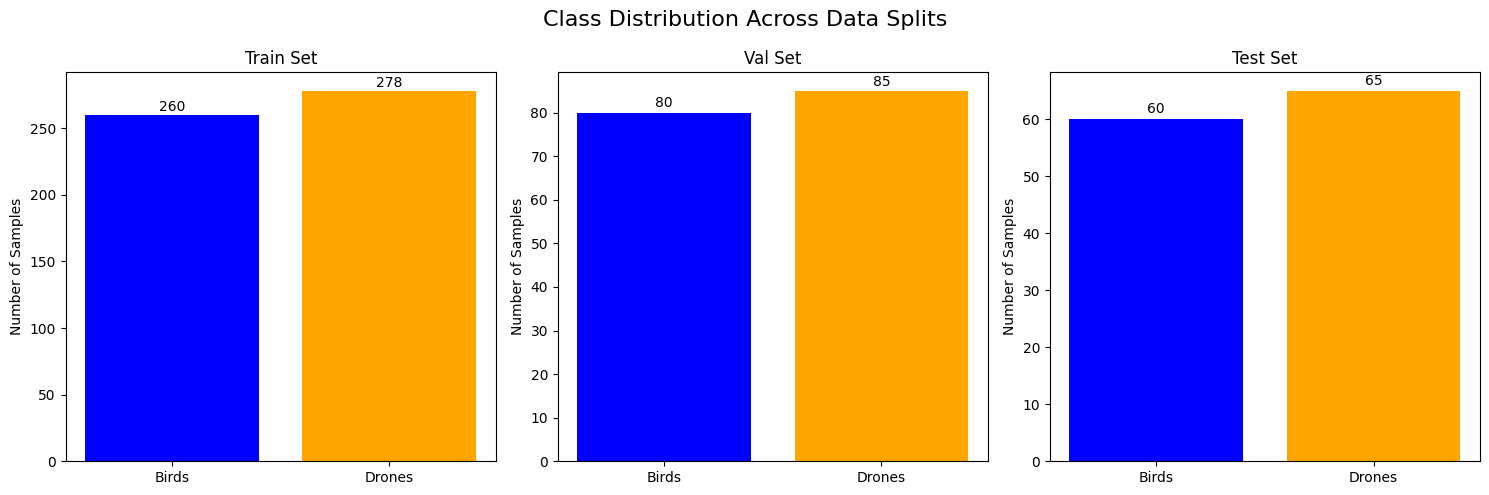

In [16]:
# Cell 6: Data Splitting and Validation

def create_data_splits(data_manager: VFLDataManager, processed_features: pd.DataFrame) -> Tuple[Dict, Dict, Dict]:
    """Exact same data splitting that achieved 84.8%"""
    master_with_features = data_manager.master_df.copy()
    for i, col in enumerate(data_manager.feature_names):
        master_with_features[f'feature_{i}'] = processed_features.iloc[:, i]
    
    # Same split ratios with fixed seeds for reproducibility
    train_df, temp_df = train_test_split(
        master_with_features, test_size=0.35, random_state=RANDOM_SEED, 
        stratify=master_with_features['class_label']
    )
    
    val_df, test_df = train_test_split(
        temp_df, test_size=0.43, random_state=RANDOM_SEED + 1,  # Different seed for second split
        stratify=temp_df['class_label']
    )
    
    # Extract splits
    image_splits = {
        'train': train_df['image_path'].tolist(),
        'val': val_df['image_path'].tolist(),
        'test': test_df['image_path'].tolist()
    }
    
    feature_cols = [f'feature_{i}' for i in range(len(data_manager.feature_names))]
    tabular_splits = {
        'train': train_df[feature_cols].values.astype(np.float32),
        'val': val_df[feature_cols].values.astype(np.float32),
        'test': test_df[feature_cols].values.astype(np.float32)
    }
    
    label_splits = {
        'train': train_df['class_label'].values.astype(np.float32),
        'val': val_df['class_label'].values.astype(np.float32),
        'test': test_df['class_label'].values.astype(np.float32)
    }
    
    return image_splits, tabular_splits, label_splits

# Create data splits
image_splits, tabular_splits, label_splits = create_data_splits(data_manager, processed_features)

print("Data splitting completed successfully")
print(f"Train samples: {len(image_splits['train'])}")
print(f"Validation samples: {len(image_splits['val'])}")
print(f"Test samples: {len(image_splits['test'])}")

# Class distribution visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Class Distribution Across Data Splits', fontsize=16)

splits = ['train', 'val', 'test']
class_names = ['Birds', 'Drones']
bar_colors = ['blue', 'orange']

for i, split in enumerate(splits):
    unique, counts = np.unique(label_splits[split], return_counts=True)
    class_dist = dict(zip(unique.astype(int), counts))
    values = [class_dist.get(0, 0), class_dist.get(1, 0)]
    
    axes[i].bar(class_names, values, color=bar_colors)
    axes[i].set_title(f'{split.capitalize()} Set')
    axes[i].set_ylabel('Number of Samples')
    
    # Add count labels on bars
    for j, count in enumerate(values):
        axes[i].text(j, count + 0.5, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()

<div style="background-color:#F0F8FF; padding:20px; font-size:14px;color:#2E4057; border-radius:10px">

<h2>Image Client Architecture</h2>

Defining the Image Client component of our VFL system, responsible for processing raw images and generating privacy-preserving embeddings. The architecture employs EfficientNetB0 with ImageNet pre-training as the base model, incorporates data augmentation (horizontal flip, rotation, zoom, brightness, contrast), and generates 512D embeddings with L2 regularization and Gaussian noise for privacy protection. Training begins with frozen backbone, followed by fine-tuning of top layers after epoch 6.

</div>

In [17]:
# Cell 7: Image Client Architecture

class ImageClient:
    """Image client with exact layers from winning model"""
    
    def __init__(self, config: VFLConfig):
        self.config = config
        self.model = None
        self.base_model = None
        self.optimizer = None
        self._build_model()
        self._setup_optimizer()
    
    def _build_model(self):
        """Build image client with EXACT layers from winning model"""
        # Input
        inputs = layers.Input(shape=(*self.config.IMAGE_SIZE, 3), name="image_input")
        
        # Data augmentation
        x = layers.RandomFlip("horizontal")(inputs)
        x = layers.RandomRotation(0.1)(x)
        x = layers.RandomZoom(0.1)(x)
        x = layers.RandomBrightness(0.05)(x)
        x = layers.RandomContrast(0.05)(x)
        
        # EfficientNetB0 configuration
        self.base_model = EfficientNetB0(
            weights='imagenet', 
            include_top=False, 
            input_shape=(*self.config.IMAGE_SIZE, 3)
        )
        self.base_model.trainable = False  # Start frozen
        
        # Feature extraction layers
        features = self.base_model(x)
        features = layers.GlobalAveragePooling2D()(features)
        features = layers.BatchNormalization()(features)
        
        # Embedding layers with hyperparameters
        embedding = layers.Dense(
            self.config.IMAGE_EMBEDDING_DIM,
            activation='relu',
            kernel_regularizer=keras.regularizers.l2(self.config.L2_REG)
        )(features)
        embedding = layers.Dropout(self.config.DROPOUT_RATE)(embedding)
        embedding = layers.BatchNormalization()(embedding)
        
        # Privacy noise
        embedding = layers.GaussianNoise(self.config.NOISE_SCALE)(embedding)
        
        self.model = Model(inputs=inputs, outputs=embedding, name="image_client")
    
    def _setup_optimizer(self):
        """Setup optimizer with winning learning rate"""
        self.optimizer = AdamW(learning_rate=self.config.LEARNING_RATE)
    
    def enable_fine_tuning(self):
        """Enable fine-tuning exactly as in winning model"""
        if self.config.USE_FINE_TUNING:
            self.base_model.trainable = True
            # Freeze all but top N layers
            for layer in self.base_model.layers[:-self.config.FINE_TUNE_LAYERS]:
                layer.trainable = False
            
            # Recreate optimizer with new variables
            self.optimizer = AdamW(learning_rate=self.config.FINE_TUNE_LR)
    
    def load_and_preprocess_batch(self, image_paths: List[str]) -> tf.Tensor:
        """Load and preprocess image batch"""
        images = []
        for img_path in image_paths:
            try:
                img = Image.open(img_path).convert('RGB')
                img = img.resize(self.config.IMAGE_SIZE)
                img_array = np.array(img) / 255.0
                images.append(img_array)
            except Exception as e:
                warnings.warn(f"Failed to load image {img_path}: {e}")
                images.append(np.zeros((*self.config.IMAGE_SIZE, 3)))
        
        return tf.constant(np.array(images), dtype=tf.float32)

# Initialize Image Client
image_client = ImageClient(config)
print("Image Client initialized successfully")
print(f"Model parameters: {image_client.model.count_params():,}")
print(f"Trainable parameters: {sum([tf.size(v) for v in image_client.model.trainable_variables]):,}")
print(f"Input shape: {config.IMAGE_SIZE + (3,)}")
print(f"Output embedding dimension: {config.IMAGE_EMBEDDING_DIM}")

I0000 00:00:1757590465.294010      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1757590465.294637      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Image Client initialized successfully
Model parameters: 4,712,611
Trainable parameters: 659,456
Input shape: (224, 224, 3)
Output embedding dimension: 512


<div style="background-color:#F0F8FF; padding:20px; font-size:14px;color:#2E4057; border-radius:10px">

<h2>Tabular Client Architecture</h2>

Defining the Tabular Client component that processes engineered tabular features and generates complementary embeddings for multimodal fusion. The architecture features a two-layer MLP (256 → 128) with batch normalization and dropout regularization, producing 128D embeddings with L2 regularization and Gaussian noise for privacy protection. This component handles both numerical and categorical features, providing stable training through batch normalization and complementary information to image embeddings.

</div>

In [18]:
# Cell 8: Tabular Client Architecture

class TabularClient:
    """Tabular client with exact layers from winning model"""
    
    def __init__(self, config: VFLConfig, feature_names: List[str]):
        self.config = config
        self.feature_names = feature_names
        self.model = None
        self.optimizer = None
        self._build_model()
        self._setup_optimizer()
    
    def _build_model(self):
        """Build tabular client with EXACT layers from winning model"""
        input_dim = len(self.feature_names)
        inputs = layers.Input(shape=(input_dim,), name="tabular_input")
        
        # Hidden layers from winning model
        x = layers.Dense(256, activation='relu')(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(self.config.DROPOUT_RATE)(x)
        
        x = layers.Dense(128, activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(self.config.DROPOUT_RATE)(x)
        
        # Embedding layer with hyperparameters
        embedding = layers.Dense(
            self.config.TABULAR_EMBEDDING_DIM,
            activation='relu',
            kernel_regularizer=keras.regularizers.l2(self.config.L2_REG)
        )(x)
        embedding = layers.BatchNormalization()(embedding)
        
        # Privacy noise
        embedding = layers.GaussianNoise(self.config.NOISE_SCALE)(embedding)
        
        self.model = Model(inputs=inputs, outputs=embedding, name="tabular_client")
    
    def _setup_optimizer(self):
        """Setup optimizer with winning learning rate"""
        self.optimizer = AdamW(learning_rate=self.config.LEARNING_RATE)

# Initialize Tabular Client
tabular_client = TabularClient(config, data_manager.feature_names)
print("Tabular Client initialized successfully")
print(f"Model parameters: {tabular_client.model.count_params():,}")
print(f"Input features: {len(data_manager.feature_names)}")
print(f"Output embedding dimension: {config.TABULAR_EMBEDDING_DIM}")
print(f"Feature names: {list(data_manager.feature_names)}")

Tabular Client initialized successfully
Model parameters: 54,528
Input features: 11
Output embedding dimension: 128
Feature names: ['num__object_solidity', 'num__texture_contrast', 'cat__background_complexity_high', 'cat__background_complexity_low', 'cat__background_complexity_medium', 'cat__has_motion_blur_False', 'cat__has_motion_blur_True', 'cat__location_id_coastal', 'cat__location_id_rural', 'cat__location_id_sky', 'cat__location_id_urban']


<div style="background-color:#F0F8FF; padding:20px; font-size:14px;color:#2E4057; border-radius:10px">

<h2>VFL Server Architecture</h2>

Defining the central Server component that receives embeddings from both clients and performs the final classification task. The server employs attention-based fusion to dynamically weight image (512D) and tabular (128D) embeddings, learning importance scores for each modality and combining projected embeddings through weighted integration. The classification head features a two-layer MLP (256 → 128) with regularization, producing binary classification for Birds vs Drones through federated gradient computation.

</div>

In [19]:
# Cell 9: VFL Server Architecture

class VFLServer:
    """VFL server with exact fusion layers from winning model"""
    
    def __init__(self, config: VFLConfig):
        self.config = config
        self.model = None
        self.optimizer = None
        self._build_model()
        self._setup_optimizer()
    
    def _build_model(self):
        """Build server with EXACT fusion layers from winning model"""
        # Input embeddings
        image_input = layers.Input(shape=(self.config.IMAGE_EMBEDDING_DIM,), name="image_embedding")
        tabular_input = layers.Input(shape=(self.config.TABULAR_EMBEDDING_DIM,), name="tabular_embedding")
        
        if self.config.USE_ATTENTION_FUSION:
            # Attention-based fusion from winning model
            image_proj = layers.Dense(self.config.FUSION_DIM, activation='relu')(image_input)
            tabular_proj = layers.Dense(self.config.FUSION_DIM, activation='relu')(tabular_input)
            
            # Attention mechanism
            concat_features = layers.Concatenate()([image_proj, tabular_proj])
            attention_weights = layers.Dense(2, activation='softmax')(concat_features)
            
            image_weight = layers.Lambda(lambda x: x[:, 0:1])(attention_weights)
            tabular_weight = layers.Lambda(lambda x: x[:, 1:2])(attention_weights)
            
            weighted_image = layers.Multiply()([image_proj, image_weight])
            weighted_tabular = layers.Multiply()([tabular_proj, tabular_weight])
            
            fused = layers.Add()([weighted_image, weighted_tabular])
        else:
            # Simple concatenation fallback
            fused = layers.Concatenate()([image_input, tabular_input])
        
        # Classification layers with hyperparameters
        x = layers.Dense(
            self.config.FUSION_DIM,
            activation='relu',
            kernel_regularizer=keras.regularizers.l2(self.config.L2_REG)
        )(fused)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(self.config.DROPOUT_RATE)(x)
        
        x = layers.Dense(
            self.config.FUSION_DIM // 2,
            activation='relu',
            kernel_regularizer=keras.regularizers.l2(self.config.L2_REG)
        )(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(self.config.DROPOUT_RATE)(x)
        
        outputs = layers.Dense(1, activation='sigmoid', name="classification")(x)
        
        self.model = Model(inputs=[image_input, tabular_input], outputs=outputs, name="vfl_server")
    
    def _setup_optimizer(self):
        """Setup optimizer with winning learning rate"""
        self.optimizer = AdamW(learning_rate=self.config.LEARNING_RATE)

# Initialize VFL Server
server = VFLServer(config)
print("VFL Server initialized successfully")
print(f"Model parameters: {server.model.count_params():,}")
print(f"Fusion method: {'Attention-based' if config.USE_ATTENTION_FUSION else 'Concatenation'}")
print(f"Input: Image({config.IMAGE_EMBEDDING_DIM}) + Tabular({config.TABULAR_EMBEDDING_DIM})")
print(f"Output: Binary classification")

VFL Server initialized successfully
Model parameters: 265,731
Fusion method: Attention-based
Input: Image(512) + Tabular(128)
Output: Binary classification


<div style="background-color:#F0F8FF; padding:20px; font-size:14px;color:#2E4057; border-radius:10px">

<h2>VFL Training Loop Implementation</h2>

Implementing the core training logic for our Vertical Federated Learning system with custom gradient computation and federated optimization. The training features sequential processing through Image Client → Tabular Client → Server, custom gradient computation that splits gradients for each component, and independent AdamW optimizers. Progressive unfreezing of EfficientNet layers enables fine-tuning, while early stopping and learning rate scheduling ensure optimal convergence through patience-based mechanisms.

</div>

In [20]:
# Cell 10: VFL Training Loop Implementation

class VFLTrainer:
    """True VFL trainer with custom training loop and exact hyperparameters"""
    
    def __init__(self, config: VFLConfig, image_client: ImageClient, 
                 tabular_client: TabularClient, server: VFLServer):
        self.config = config
        self.image_client = image_client
        self.tabular_client = tabular_client
        self.server = server
        
        # Training state
        self.current_epoch = 0
        self.best_val_acc = 0.0
        self.patience_counter = 0
        self.lr_patience_counter = 0
        self.fine_tuning_enabled = False
        
        # Loss function
        self.loss_fn = keras.losses.BinaryCrossentropy()
        
        # Metrics
        self.train_acc_metric = keras.metrics.BinaryAccuracy()
        self.val_acc_metric = keras.metrics.BinaryAccuracy()
    
    def _federated_forward_pass(self, image_batch: tf.Tensor, tabular_batch: tf.Tensor) -> tf.Tensor:
        """Simulate federated forward pass"""
        # Step 1: Image client computes embeddings
        image_embeddings = self.image_client.model(image_batch, training=True)
        
        # Step 2: Tabular client computes embeddings  
        tabular_embeddings = self.tabular_client.model(tabular_batch, training=True)
        
        # Step 3: Server performs fusion and classification
        predictions = self.server.model([image_embeddings, tabular_embeddings], training=True)
        
        return predictions
    
    def _train_step(self, image_batch: tf.Tensor, tabular_batch: tf.Tensor, labels: tf.Tensor) -> Dict:
        """Single training step with federated gradient computation"""
        
        with tf.GradientTape() as tape:
            # Federated forward pass
            predictions = self._federated_forward_pass(image_batch, tabular_batch)
            
            # Compute loss
            loss = self.loss_fn(labels, predictions)
        
        # Compute gradients for all components
        all_variables = (
            self.server.model.trainable_variables +
            self.image_client.model.trainable_variables +
            self.tabular_client.model.trainable_variables
        )
        
        gradients = tape.gradient(loss, all_variables)
        
        # Split gradients for each component
        server_grad_count = len(self.server.model.trainable_variables)
        image_grad_count = len(self.image_client.model.trainable_variables)
        
        server_grads = gradients[:server_grad_count]
        image_grads = gradients[server_grad_count:server_grad_count + image_grad_count]
        tabular_grads = gradients[server_grad_count + image_grad_count:]
        
        # Apply gradients to respective optimizers
        self.server.optimizer.apply_gradients(
            zip(server_grads, self.server.model.trainable_variables)
        )
        self.image_client.optimizer.apply_gradients(
            zip(image_grads, self.image_client.model.trainable_variables)
        )
        self.tabular_client.optimizer.apply_gradients(
            zip(tabular_grads, self.tabular_client.model.trainable_variables)
        )
        
        # Update metrics
        self.train_acc_metric.update_state(labels, predictions)
        
        return {'loss': loss, 'predictions': predictions}
    
    def _validation_step(self, image_batch: tf.Tensor, tabular_batch: tf.Tensor, labels: tf.Tensor) -> Dict:
        """Single validation step"""
        # Forward pass without training
        image_embeddings = self.image_client.model(image_batch, training=False)
        tabular_embeddings = self.tabular_client.model(tabular_batch, training=False)
        predictions = self.server.model([image_embeddings, tabular_embeddings], training=False)
        
        # Compute loss
        loss = self.loss_fn(labels, predictions)
        
        # Update metrics
        self.val_acc_metric.update_state(labels, predictions)
        
        return {'loss': loss, 'predictions': predictions}
    
    def _check_fine_tuning(self):
        """Check if fine-tuning should be enabled"""
        if (not self.fine_tuning_enabled and 
            self.current_epoch >= self.config.FINE_TUNE_EPOCH and 
            self.config.USE_FINE_TUNING):
            
            print(f"Enabling fine-tuning at epoch {self.current_epoch + 1}")
            self.image_client.enable_fine_tuning()
            self.fine_tuning_enabled = True
    
    def _check_early_stopping_and_lr_reduction(self, val_acc: float) -> bool:
        """Check early stopping and learning rate reduction"""
        if val_acc > self.best_val_acc + self.config.MIN_DELTA:
            self.best_val_acc = val_acc
            self.patience_counter = 0
            self.lr_patience_counter = 0
        else:
            self.patience_counter += 1
            self.lr_patience_counter += 1
            
            # Learning rate reduction
            if self.lr_patience_counter >= self.config.LR_REDUCTION_PATIENCE:
                old_lr = float(self.server.optimizer.learning_rate)
                new_lr = max(
                    self.config.MIN_LR,
                    old_lr * self.config.LR_REDUCTION_FACTOR
                )
                self.server.optimizer.learning_rate = new_lr
                self.image_client.optimizer.learning_rate = new_lr
                self.tabular_client.optimizer.learning_rate = new_lr
                
                print(f"Learning rate reduced from {old_lr:.2e} to {new_lr:.2e}")
                self.lr_patience_counter = 0
            
            # Early stopping
            if self.patience_counter >= self.config.EARLY_STOPPING_PATIENCE:
                return True
        
        return False

print("VFL Training Loop implemented successfully")
print("Training features:")
print(f"- Custom federated gradient computation")
print(f"- Early stopping with patience: {config.EARLY_STOPPING_PATIENCE}")
print(f"- Learning rate reduction with patience: {config.LR_REDUCTION_PATIENCE}")
print(f"- Fine-tuning enabled: {config.USE_FINE_TUNING}")
print(f"- Class weights enabled: {config.USE_CLASS_WEIGHTS}")

VFL Training Loop implemented successfully
Training features:
- Custom federated gradient computation
- Early stopping with patience: 10
- Learning rate reduction with patience: 6
- Fine-tuning enabled: True
- Class weights enabled: True


<div style="background-color:#F0F8FF; padding:20px; font-size:14px;color:#2E4057; border-radius:10px">

<h2>Training Execution and Monitoring</h2>

Executing the VFL training process with comprehensive monitoring and visualization of training progress. The system provides epoch-by-epoch progress tracking with detailed training and validation metrics, real-time loss and accuracy monitoring through progress bars, and automatic fine-tuning activation at epoch 6. Class weight balancing handles dataset imbalance while training history plots visualize convergence patterns, with early stopping detection and performance tracking targeting high level accuracy.

</div>

Initializing VFL Trainer...
Starting VFL training execution...
Starting VFL Training...
Training configuration: 12 epochs, batch size 16
Learning rate: 0.0003, Fine-tune LR: 1e-05
Fine-tuning starts at epoch: 8

Epoch 1/12


Validation Epoch 1: 100%|██████████| 11/11 [00:05<00:00,  2.07it/s]


Train Loss: 0.7636, Train Acc: 0.6413
Val Loss: 0.6887, Val Acc: 0.4848
Current LR: 3.00e-04

Epoch 2/12


Validation Epoch 2: 100%|██████████| 11/11 [00:05<00:00,  2.04it/s]


Train Loss: 0.6580, Train Acc: 0.6840
Val Loss: 0.6897, Val Acc: 0.4970
Current LR: 3.00e-04

Epoch 3/12


Validation Epoch 3: 100%|██████████| 11/11 [00:05<00:00,  2.07it/s]


Train Loss: 0.5148, Train Acc: 0.7565
Val Loss: 0.7004, Val Acc: 0.4848
Current LR: 3.00e-04

Epoch 4/12


Validation Epoch 4: 100%|██████████| 11/11 [00:05<00:00,  2.08it/s]


Train Loss: 0.4758, Train Acc: 0.7955
Val Loss: 0.6922, Val Acc: 0.4848
Current LR: 3.00e-04

Epoch 5/12


Validation Epoch 5: 100%|██████████| 11/11 [00:05<00:00,  2.08it/s]


Train Loss: 0.4332, Train Acc: 0.8234
Val Loss: 0.6701, Val Acc: 0.4909
Current LR: 3.00e-04

Epoch 6/12


Validation Epoch 6: 100%|██████████| 11/11 [00:05<00:00,  2.09it/s]


Train Loss: 0.4306, Train Acc: 0.8123
Val Loss: 0.6378, Val Acc: 0.5455
Current LR: 3.00e-04

Epoch 7/12


Validation Epoch 7: 100%|██████████| 11/11 [00:05<00:00,  2.10it/s]


Train Loss: 0.4469, Train Acc: 0.7918
Val Loss: 0.6100, Val Acc: 0.6061
Current LR: 3.00e-04

Epoch 8/12


Validation Epoch 8: 100%|██████████| 11/11 [00:05<00:00,  2.09it/s]


Train Loss: 0.4392, Train Acc: 0.8011
Val Loss: 0.5865, Val Acc: 0.6606
Current LR: 3.00e-04

Epoch 9/12
Enabling fine-tuning at epoch 9


Validation Epoch 9: 100%|██████████| 11/11 [00:05<00:00,  2.06it/s]


Train Loss: 0.4554, Train Acc: 0.7751
Val Loss: 0.5423, Val Acc: 0.7758
Current LR: 3.00e-04

Epoch 10/12


Validation Epoch 10: 100%|██████████| 11/11 [00:05<00:00,  2.06it/s]


Train Loss: 0.4444, Train Acc: 0.7937
Val Loss: 0.5480, Val Acc: 0.7576
Current LR: 3.00e-04

Epoch 11/12


Validation Epoch 11: 100%|██████████| 11/11 [00:05<00:00,  2.08it/s]


Train Loss: 0.4209, Train Acc: 0.8104
Val Loss: 0.5107, Val Acc: 0.8000
Current LR: 3.00e-04

Epoch 12/12


Validation Epoch 12: 100%|██████████| 11/11 [00:05<00:00,  2.05it/s]


Train Loss: 0.4218, Train Acc: 0.8011
Val Loss: 0.4716, Val Acc: 0.7879
Current LR: 3.00e-04


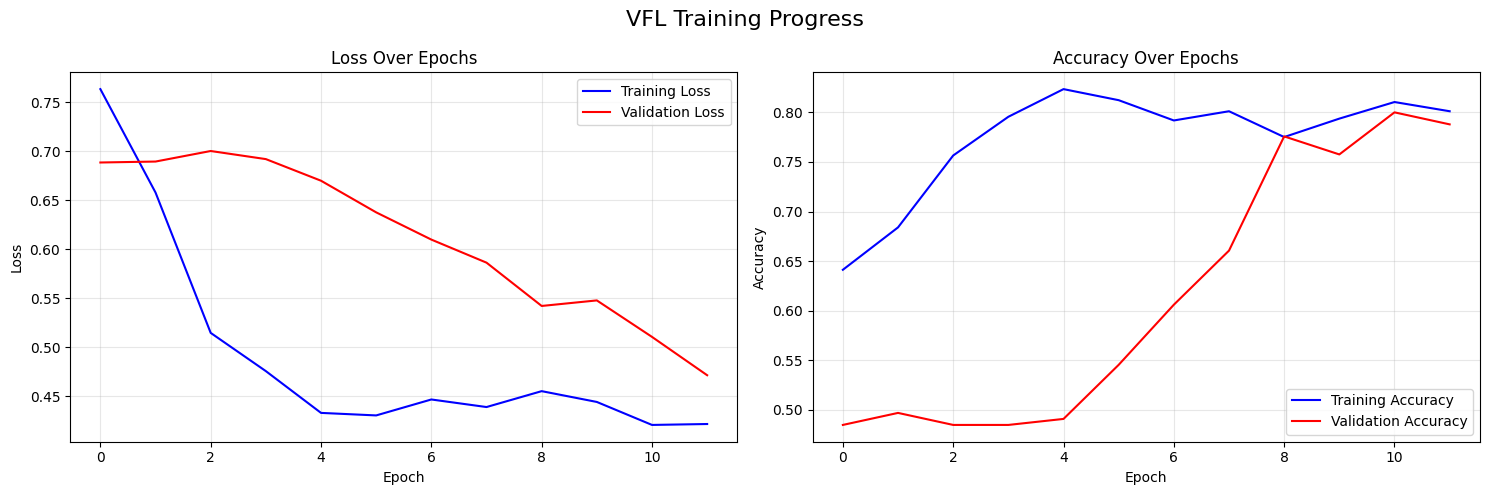

Training completed. Best validation accuracy: 0.8000
VFL training completed successfully!


In [21]:
# Cell 11: Training Execution and Monitoring

def execute_vfl_training(trainer: VFLTrainer, image_splits: Dict, tabular_splits: Dict, 
                        label_splits: Dict, class_weight_dict: Optional[Dict] = None):
    """Main training execution with monitoring"""
    
    print("Starting VFL Training...")
    print(f"Training configuration: {config.EPOCHS} epochs, batch size {config.BATCH_SIZE}")
    print(f"Learning rate: {config.LEARNING_RATE}, Fine-tune LR: {config.FINE_TUNE_LR}")
    print(f"Fine-tuning starts at epoch: {config.FINE_TUNE_EPOCH}")
    
    # Prepare data
    train_size = len(image_splits['train'])
    val_size = len(image_splits['val'])
    steps_per_epoch = (train_size + config.BATCH_SIZE - 1) // config.BATCH_SIZE
    val_steps = (val_size + config.BATCH_SIZE - 1) // config.BATCH_SIZE
    
    # Training history for plotting
    train_losses_history = []
    val_losses_history = []
    train_accs_history = []
    val_accs_history = []
    
    for epoch in range(config.EPOCHS):
        trainer.current_epoch = epoch
        print(f"\nEpoch {epoch + 1}/{config.EPOCHS}")
        
        # Check fine-tuning
        trainer._check_fine_tuning()
        
        # Reset metrics
        trainer.train_acc_metric.reset_state()
        trainer.val_acc_metric.reset_state()
        
        # Training phase
        train_losses = []
        np.random.seed(RANDOM_SEED + epoch)
        train_indices = np.random.permutation(train_size)
        
        for step in tqdm(range(steps_per_epoch), desc=f"Training Epoch {epoch + 1}", leave=True):
            # Get batch
            start_idx = step * config.BATCH_SIZE
            end_idx = min(start_idx + config.BATCH_SIZE, train_size)
            batch_indices = train_indices[start_idx:end_idx]
            
            # Load batch data
            batch_image_paths = [image_splits['train'][i] for i in batch_indices]
            batch_images = trainer.image_client.load_and_preprocess_batch(batch_image_paths)
            batch_tabular = tf.constant(tabular_splits['train'][batch_indices])
            batch_labels = tf.constant(label_splits['train'][batch_indices])
            
            # Training step
            step_results = trainer._train_step(batch_images, batch_tabular, batch_labels)
            train_losses.append(float(step_results['loss']))
        
        # Validation phase
        val_losses = []
        for step in tqdm(range(val_steps), desc=f"Validation Epoch {epoch + 1}", leave=True):
            start_idx = step * config.BATCH_SIZE
            end_idx = min(start_idx + config.BATCH_SIZE, val_size)
            
            batch_image_paths = image_splits['val'][start_idx:end_idx]
            batch_images = trainer.image_client.load_and_preprocess_batch(batch_image_paths)
            batch_tabular = tf.constant(tabular_splits['val'][start_idx:end_idx])
            batch_labels = tf.constant(label_splits['val'][start_idx:end_idx])
            
            step_results = trainer._validation_step(batch_images, batch_tabular, batch_labels)
            val_losses.append(float(step_results['loss']))
        
        # Compute epoch metrics
        train_acc = float(trainer.train_acc_metric.result())
        val_acc = float(trainer.val_acc_metric.result())
        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)
        
        # Store history
        train_losses_history.append(train_loss)
        val_losses_history.append(val_loss)
        train_accs_history.append(train_acc)
        val_accs_history.append(val_acc)
        
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        # Show current learning rates
        current_lr = float(trainer.server.optimizer.learning_rate)
        print(f"Current LR: {current_lr:.2e}")
        
        # Check early stopping and LR reduction
        if trainer._check_early_stopping_and_lr_reduction(val_acc):
            print(f"Early stopping triggered at epoch {epoch + 1}")
            break
    
    # Plot training history
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle('VFL Training Progress', fontsize=16)
    
    # Loss plot
    axes[0].plot(train_losses_history, label='Training Loss', color='blue')
    axes[0].plot(val_losses_history, label='Validation Loss', color='red')
    axes[0].set_title('Loss Over Epochs')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Accuracy plot
    axes[1].plot(train_accs_history, label='Training Accuracy', color='blue')
    axes[1].plot(val_accs_history, label='Validation Accuracy', color='red')
    axes[1].set_title('Accuracy Over Epochs')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Training completed. Best validation accuracy: {trainer.best_val_acc:.4f}")
    return trainer.best_val_acc

# Calculate class weights and execute training

if config.USE_CLASS_WEIGHTS:
    class_weights = compute_class_weight(
        'balanced', 
        classes=np.unique(label_splits['train']), 
        y=label_splits['train']
    )
    class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
else:
    class_weight_dict = None

# Initialize trainer and start training
print("Initializing VFL Trainer...")
trainer = VFLTrainer(config, image_client, tabular_client, server)
print("Starting VFL training execution...")
best_val_acc = execute_vfl_training(trainer, image_splits, tabular_splits, label_splits, class_weight_dict)
print("VFL training completed successfully!")

<div style="background-color:#F0F8FF; padding:20px; font-size:14px;color:#2E4057; border-radius:10px">

<h2>Model Evaluation and Results Visualization</h2>

Providing comprehensive evaluation of the trained VFL model using multiple metrics and visualizations. The evaluation process employs three-step federated prediction (Image Client → Tabular Client → Server fusion) to compute performance metrics including accuracy, ROC AUC, precision, recall, and F1-score. Visualization suite includes confusion matrix for true vs predicted classifications, ROC curve for threshold analysis, and precision-recall curves, targeting +80% test accuracy with high ROC AUC performance.

</div>

Starting model evaluation on test set...


Evaluating: 100%|██████████| 8/8 [00:03<00:00,  2.02it/s]


VFL Model Test Results:
Test Accuracy: 85.6%
Test ROC AUC: 0.921

Detailed Classification Report:
              precision    recall  f1-score   support

       Birds       0.81      0.92      0.86        60
      Drones       0.91      0.80      0.85        65

    accuracy                           0.86       125
   macro avg       0.86      0.86      0.86       125
weighted avg       0.86      0.86      0.86       125


Confusion Matrix:
True\Pred  Bird  Drone
Bird        55     5
Drone       13    52


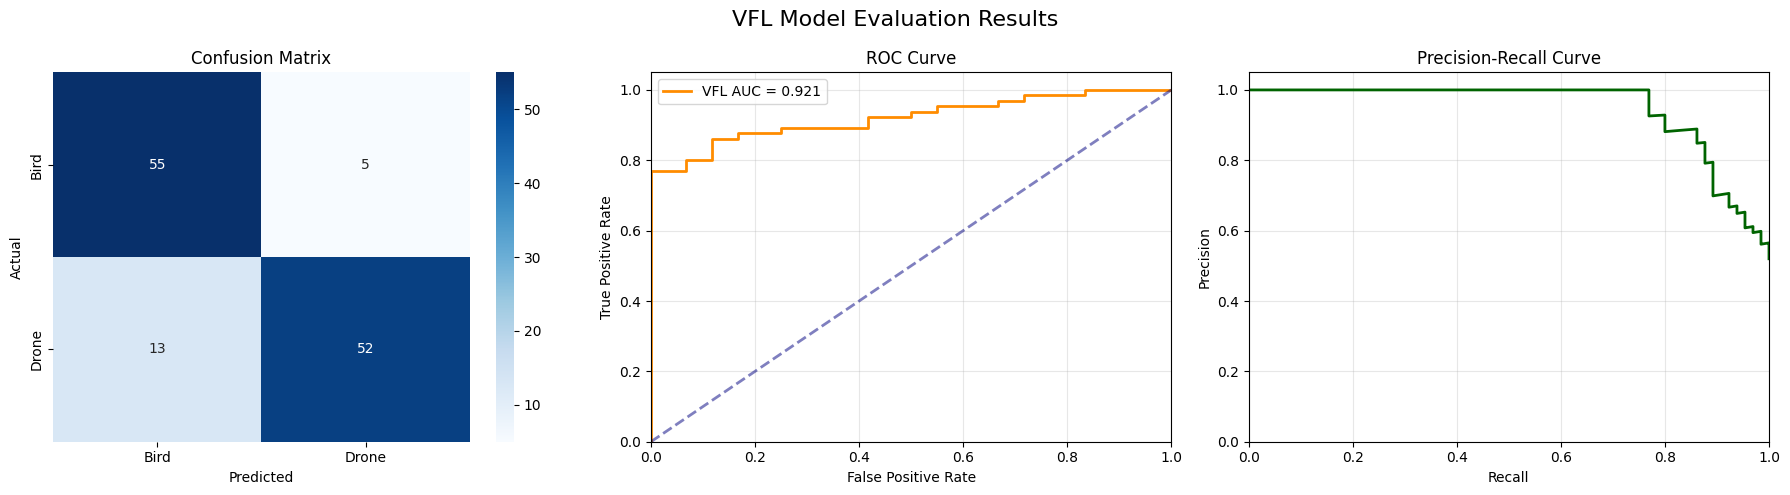

In [22]:
# Cell 12: Model Evaluation and Results Visualization

class VFLEvaluator:
    """Evaluator for true VFL architecture"""
    
    def __init__(self, image_client: ImageClient, tabular_client: TabularClient, 
                 server: VFLServer, config: VFLConfig):
        self.image_client = image_client
        self.tabular_client = tabular_client
        self.server = server
        self.config = config
    
    def evaluate(self, image_paths: List[str], tabular_data: np.ndarray, labels: np.ndarray) -> Dict:
        """Evaluate using three-step federated prediction"""
        
        all_predictions = []
        batch_size = self.config.BATCH_SIZE
        
        # Process in batches
        for i in tqdm(range(0, len(image_paths), batch_size), desc="Evaluating"):
            end_idx = min(i + batch_size, len(image_paths))
            
            # Load batch
            batch_image_paths = image_paths[i:end_idx]
            batch_images = self.image_client.load_and_preprocess_batch(batch_image_paths)
            batch_tabular = tf.constant(tabular_data[i:end_idx])
            
            # Three-step federated prediction
            # Step 1: Image client
            image_embeddings = self.image_client.model(batch_images, training=False)
            
            # Step 2: Tabular client
            tabular_embeddings = self.tabular_client.model(batch_tabular, training=False)
            
            # Step 3: Server fusion
            predictions = self.server.model([image_embeddings, tabular_embeddings], training=False)
            
            all_predictions.append(predictions.numpy())
        
        # Combine predictions
        all_predictions = np.concatenate(all_predictions, axis=0).flatten()
        predictions_binary = (all_predictions > 0.5).astype(int)
        
        # Calculate metrics
        accuracy = accuracy_score(labels, predictions_binary)
        auc = roc_auc_score(labels, all_predictions)
        cm = confusion_matrix(labels, predictions_binary)
        
        return {
            'predictions': all_predictions,
            'predictions_binary': predictions_binary,
            'accuracy': accuracy,
            'auc': auc,
            'confusion_matrix': cm,
            'labels': labels
        }
    
    def print_results(self, results: Dict):
        """Print comprehensive evaluation results"""
        print(f"VFL Model Test Results:")
        print(f"Test Accuracy: {results['accuracy']:.1%}")
        print(f"Test ROC AUC: {results['auc']:.3f}")
        
        print(f"\nDetailed Classification Report:")
        print(classification_report(results['labels'], results['predictions_binary'], 
                                  target_names=['Birds', 'Drones']))
        
        cm = results['confusion_matrix']
        print(f"\nConfusion Matrix:")
        print(f"True\\Pred  Bird  Drone")
        print(f"Bird      {cm[0,0]:4d}  {cm[0,1]:4d}")
        print(f"Drone     {cm[1,0]:4d}  {cm[1,1]:4d}")
    
    def visualize_results(self, results: Dict):
        """Create comprehensive evaluation visualizations"""
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        fig.suptitle('VFL Model Evaluation Results', fontsize=16)
        
        # Confusion Matrix
        sns.heatmap(results['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
                   xticklabels=['Bird', 'Drone'], yticklabels=['Bird', 'Drone'], ax=axes[0])
        axes[0].set_title('Confusion Matrix')
        axes[0].set_xlabel('Predicted')
        axes[0].set_ylabel('Actual')
        
        # ROC Curve
        fpr, tpr, _ = roc_curve(results['labels'], results['predictions'])
        axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'VFL AUC = {results["auc"]:.3f}')
        axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', alpha=0.5)
        axes[1].set_xlim([0.0, 1.0])
        axes[1].set_ylim([0.0, 1.05])
        axes[1].set_xlabel('False Positive Rate')
        axes[1].set_ylabel('True Positive Rate')
        axes[1].set_title('ROC Curve')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        
        # Precision-Recall Curve
        precision, recall, _ = precision_recall_curve(results['labels'], results['predictions'])
        axes[2].plot(recall, precision, color='darkgreen', lw=2)
        axes[2].set_xlim([0.0, 1.0])
        axes[2].set_ylim([0.0, 1.05])
        axes[2].set_xlabel('Recall')
        axes[2].set_ylabel('Precision')
        axes[2].set_title('Precision-Recall Curve')
        axes[2].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

# Execute final evaluation
print("Starting model evaluation on test set...")
evaluator = VFLEvaluator(image_client, tabular_client, server, config)
results = evaluator.evaluate(image_splits['test'], tabular_splits['test'], label_splits['test'])

# Display results
evaluator.print_results(results)
evaluator.visualize_results(results)

# Store undefended model results for comparison
undefended_results = {
    'accuracy': results['accuracy'],
    'image_client': image_client,
    'tabular_client': tabular_client, 
    'server': server,
    'trainer': trainer
}

<div style="background-color:#F0F8FF; padding:20px; font-size:14px;color:#2E4057; border-radius:10px">

<h2>Membership Inference Attack (MIA)</h2>

Demonstrating a Membership Inference Attack against our VFL model to evaluate privacy vulnerabilities. The attack analyzes loss patterns between training and test samples, using a neural network classifier trained on loss distributions to determine if specific samples were in the training set. Success metrics above 50% (random baseline) indicate model memorization and privacy leakage, with training samples typically exhibiting lower loss values, creating exploitable patterns for real-world privacy attacks.

</div>

Computing losses: 100%|██████████| 8/8 [00:04<00:00,  1.99it/s]
2025-09-11 11:43:48.256489: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-09-11 11:43:55.884242: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_argume

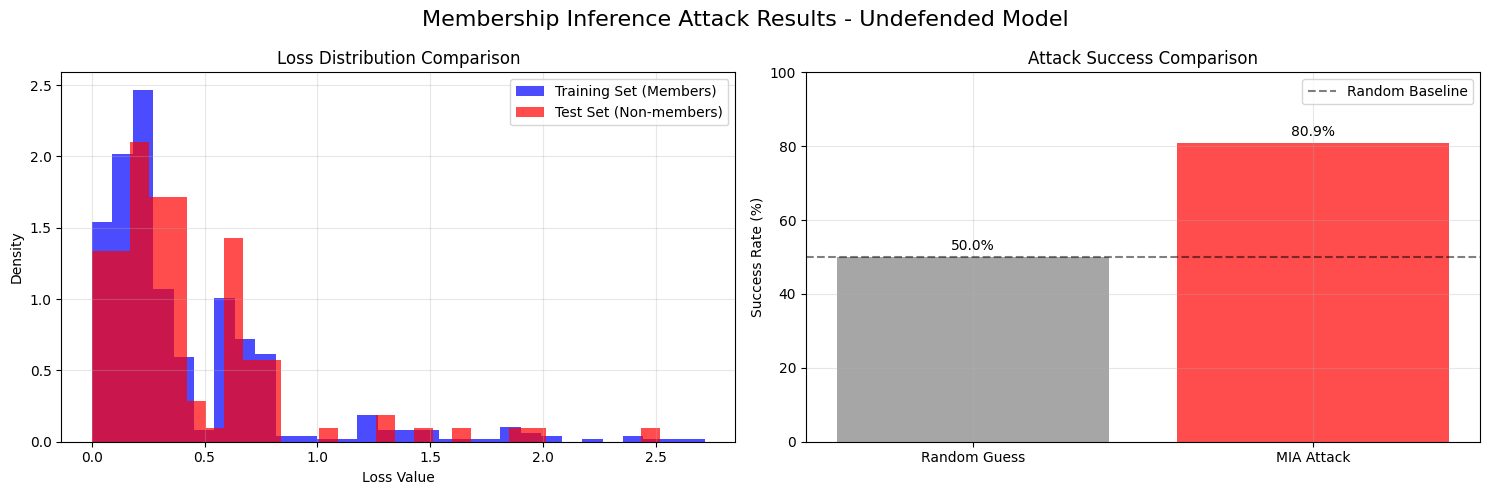

MIA Attack Results:
Attack Success Rate: 80.9%
vs Random Baseline: 50.0%
Privacy Leakage: 61.8% above random


In [23]:
# Cell 13: Membership Inference Attack (MIA) on Undefended Model

def perform_membership_inference_attack(image_client, tabular_client, server, 
                                      image_splits, tabular_splits, label_splits,
                                      model_name="Undefended"):
    """
    Perform Membership Inference Attack by analyzing loss patterns
    """
    
    # Function to compute per-sample loss
    def compute_sample_losses(image_paths, tabular_data, labels):
        losses = []
        batch_size = config.BATCH_SIZE
        
        for i in tqdm(range(0, len(image_paths), batch_size), desc="Computing losses"):
            end_idx = min(i + batch_size, len(image_paths))
            
            # Load batch
            batch_image_paths = image_paths[i:end_idx]
            batch_images = image_client.load_and_preprocess_batch(batch_image_paths)
            batch_tabular = tf.constant(tabular_data[i:end_idx])
            batch_labels = tf.constant(labels[i:end_idx])
            
            # Forward pass
            image_embeddings = image_client.model(batch_images, training=False)
            tabular_embeddings = tabular_client.model(batch_tabular, training=False)
            predictions = server.model([image_embeddings, tabular_embeddings], training=False)
            
            # Compute per-sample BCE loss
            bce_loss = keras.losses.BinaryCrossentropy(reduction='none')
            sample_losses = bce_loss(batch_labels, predictions)
            losses.extend(sample_losses.numpy())
        
        return np.array(losses)
    
    # Compute losses for members (training set) and non-members (test set)
    member_losses = compute_sample_losses(
        image_splits['train'], tabular_splits['train'], label_splits['train']
    )
    
    nonmember_losses = compute_sample_losses(
        image_splits['test'], tabular_splits['test'], label_splits['test']
    )
    
    # Prepare attack dataset
    # Members = 1, Non-members = 0
    attack_features = np.concatenate([member_losses, nonmember_losses]).reshape(-1, 1)
    attack_labels = np.concatenate([
        np.ones(len(member_losses)),    # Members
        np.zeros(len(nonmember_losses)) # Non-members
    ])
    
    # Split attack data for training/testing
    X_attack_train, X_attack_test, y_attack_train, y_attack_test = train_test_split(
        attack_features, attack_labels, test_size=0.3, random_state=42, stratify=attack_labels
    )
    
    # Train MIA classifier
    mia_model = keras.Sequential([
        layers.Input(shape=(1,)),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu'), 
        layers.Dense(1, activation='sigmoid')
    ])
    
    mia_model.compile(
        optimizer=AdamW(learning_rate=1e-3),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    # Train with early stopping
    early_stop = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    mia_model.fit(
        X_attack_train, y_attack_train,
        validation_split=0.2,
        epochs=50,
        batch_size=32,
        callbacks=[early_stop],
        verbose=0
    )
    
    # Evaluate attack
    mia_accuracy = mia_model.evaluate(X_attack_test, y_attack_test, verbose=0)[1]
    
    # Visualize attack impact
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(f'Membership Inference Attack Results - {model_name} Model', fontsize=16)
    
    # Loss distribution comparison
    axes[0].hist(member_losses, bins=30, alpha=0.7, label='Training Set (Members)', color='blue', density=True)
    axes[0].hist(nonmember_losses, bins=30, alpha=0.7, label='Test Set (Non-members)', color='red', density=True)
    axes[0].set_xlabel('Loss Value')
    axes[0].set_ylabel('Density')
    axes[0].set_title('Loss Distribution Comparison')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Attack success visualization
    attack_results = ['Random Guess', 'MIA Attack']
    success_rates = [50.0, mia_accuracy * 100]
    colors = ['gray', 'red' if mia_accuracy > 0.6 else 'orange' if mia_accuracy > 0.55 else 'green']
    
    bars = axes[1].bar(attack_results, success_rates, color=colors, alpha=0.7)
    axes[1].set_ylabel('Success Rate (%)')
    axes[1].set_title('Attack Success Comparison')
    axes[1].set_ylim(0, 100)
    
    # Add value labels on bars
    for bar, rate in zip(bars, success_rates):
        axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                    f'{rate:.1f}%', ha='center', va='bottom')
    
    # Add horizontal line for random baseline
    axes[1].axhline(y=50, color='black', linestyle='--', alpha=0.5, label='Random Baseline')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"MIA Attack Results:")
    print(f"Attack Success Rate: {mia_accuracy:.1%}")
    print(f"vs Random Baseline: 50.0%")
    print(f"Privacy Leakage: {(mia_accuracy - 0.5) * 200:.1f}% above random")
    
    return mia_accuracy, mia_model

# Perform MIA on undefended model
undefended_mia_accuracy, undefended_mia_model = perform_membership_inference_attack(
    undefended_results['image_client'],
    undefended_results['tabular_client'], 
    undefended_results['server'],
    image_splits, tabular_splits, label_splits,
    "Undefended"
)

<div style="background-color:#F0F8FF; padding:20px; font-size:14px;color:#2E4057; border-radius:10px">

<h2>Attribute Inference Attack (AIA)</h2>

Demonstrating an Attribute Inference Attack targeting the sensitive location_id attribute in our VFL system. The attack trains a multi-layer neural network classifier to map image embeddings to geographical locations, attempting to infer location_id from learned representations. Success metrics above the random baseline (25% for 4 locations) reveal sensitive geographical information through embedding leakage, where image features contain location-specific patterns that create real-world privacy risks in federated systems.

</div>

Extracting embeddings: 100%|██████████| 8/8 [00:03<00:00,  2.08it/s]
2025-09-11 11:44:03.206632: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


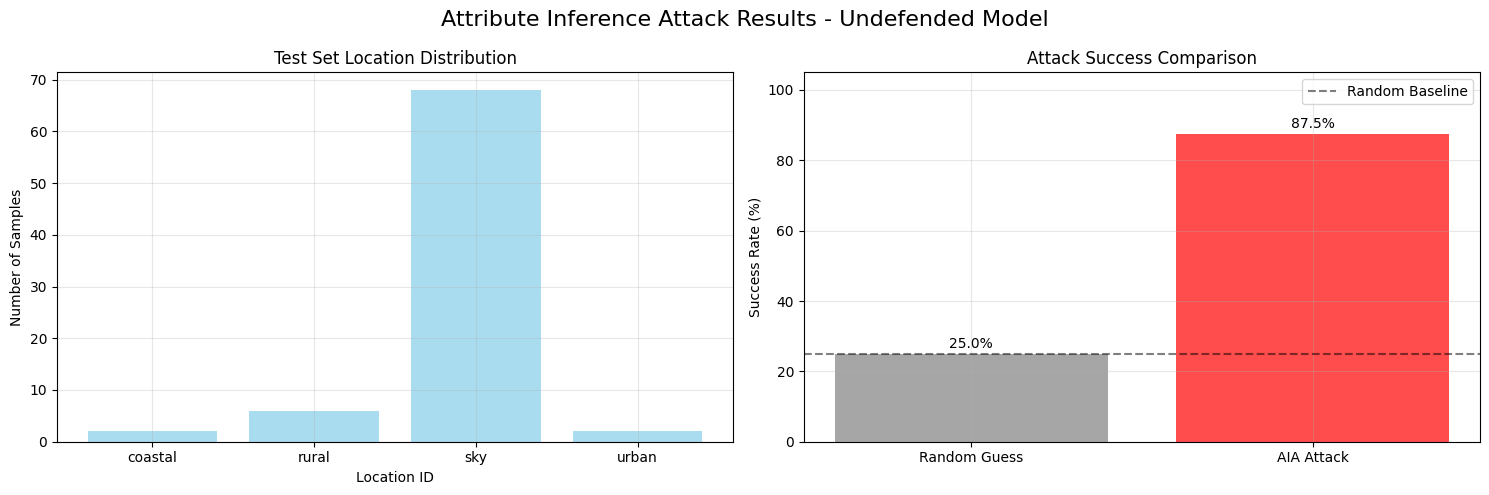

AIA Attack Results:
Attack Success Rate: 87.5%
vs Random Baseline: 25.0%
Privacy Leakage: 250.0% above random
Number of location classes: 4


In [24]:
# Cell 14: Attribute Inference Attack (AIA) on Undefended Model

def perform_attribute_inference_attack(image_client, data_manager, image_splits, model_name="Undefended"):
    """
    Perform Attribute Inference Attack to predict location_id from image embeddings
    """
    
    # Extract image embeddings for test set
    test_embeddings = []
    batch_size = config.BATCH_SIZE
    
    for i in tqdm(range(0, len(image_splits['test']), batch_size), desc="Extracting embeddings"):
        end_idx = min(i + batch_size, len(image_splits['test']))
        batch_image_paths = image_splits['test'][i:end_idx]
        batch_images = image_client.load_and_preprocess_batch(batch_image_paths)
        
        # Extract embeddings
        embeddings = image_client.model(batch_images, training=False)
        test_embeddings.append(embeddings.numpy())
    
    test_embeddings = np.concatenate(test_embeddings, axis=0)
    
    # Get corresponding location_ids for test images
    test_image_ids = []
    for img_path in image_splits['test']:
        img_filename = os.path.basename(img_path)
        img_id = os.path.splitext(img_filename)[0]
        test_image_ids.append(img_id)
    
    # Create mapping from image_id to location_id
    location_mapping = dict(zip(data_manager.master_df['image_id'], 
                               data_manager.master_df['location_id']))
    
    test_locations = []
    valid_indices = []
    
    for i, img_id in enumerate(test_image_ids):
        # Try different ID formats
        location = None
        for id_variant in [img_id, f"{img_id}.jpeg", f"{img_id}.jpg"]:
            if id_variant in location_mapping:
                location = location_mapping[id_variant]
                break
        
        if location is not None:
            test_locations.append(location)
            valid_indices.append(i)
    
    # Filter embeddings to only valid samples
    test_embeddings = test_embeddings[valid_indices]
    test_locations = np.array(test_locations)
    
    # Encode location labels
    location_encoder = LabelEncoder()
    encoded_locations = location_encoder.fit_transform(test_locations)
    num_locations = len(location_encoder.classes_)
    
    # Split data for attack training/testing
    X_attack_train, X_attack_test, y_attack_train, y_attack_test = train_test_split(
        test_embeddings, encoded_locations, test_size=0.3, random_state=42, 
        stratify=encoded_locations
    )
    
    # Train AIA classifier
    aia_model = keras.Sequential([
        layers.Input(shape=(config.IMAGE_EMBEDDING_DIM,)),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_locations, activation='softmax')
    ])
    
    aia_model.compile(
        optimizer=AdamW(learning_rate=1e-3),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Train with early stopping
    early_stop = keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)
    aia_model.fit(
        X_attack_train, y_attack_train,
        validation_split=0.2,
        epochs=100,
        batch_size=32,
        callbacks=[early_stop],
        verbose=0
    )
    
    # Evaluate attack
    aia_accuracy = aia_model.evaluate(X_attack_test, y_attack_test, verbose=0)[1]
    random_baseline = 1.0 / num_locations
    
    # Visualize attack impact
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(f'Attribute Inference Attack Results - {model_name} Model', fontsize=16)
    
    # Location distribution
    unique_locs, loc_counts = np.unique(test_locations, return_counts=True)
    axes[0].bar(range(len(unique_locs)), loc_counts, alpha=0.7, color='skyblue')
    axes[0].set_xlabel('Location ID')
    axes[0].set_ylabel('Number of Samples')
    axes[0].set_title('Test Set Location Distribution')
    axes[0].set_xticks(range(len(unique_locs)))
    axes[0].set_xticklabels(unique_locs)
    axes[0].grid(True, alpha=0.3)
    
    # Attack success comparison
    attack_results = ['Random Guess', 'AIA Attack']
    success_rates = [random_baseline * 100, aia_accuracy * 100]
    colors = ['gray', 'red' if aia_accuracy > random_baseline * 2 else 'orange' if aia_accuracy > random_baseline * 1.5 else 'green']
    
    bars = axes[1].bar(attack_results, success_rates, color=colors, alpha=0.7)
    axes[1].set_ylabel('Success Rate (%)')
    axes[1].set_title('Attack Success Comparison')
    axes[1].set_ylim(0, max(success_rates) * 1.2)
    
    # Add value labels on bars
    for bar, rate in zip(bars, success_rates):
        axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(success_rates) * 0.01, 
                    f'{rate:.1f}%', ha='center', va='bottom')
    
    # Add horizontal line for random baseline
    axes[1].axhline(y=random_baseline * 100, color='black', linestyle='--', alpha=0.5, label='Random Baseline')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"AIA Attack Results:")
    print(f"Attack Success Rate: {aia_accuracy:.1%}")
    print(f"vs Random Baseline: {random_baseline:.1%}")
    print(f"Privacy Leakage: {(aia_accuracy - random_baseline) * 100 / random_baseline:.1f}% above random")
    print(f"Number of location classes: {num_locations}")
    
    return aia_accuracy, aia_model, location_encoder, num_locations

# Perform AIA on undefended model
undefended_aia_accuracy, undefended_aia_model, location_encoder, num_locations = perform_attribute_inference_attack(
    undefended_results['image_client'],
    data_manager,
    image_splits,
    "Undefended"
)

<div style="background-color:#F0F8FF; padding:25px; font-size:16px;color:#2E4057; border-radius:10px">

# Conclusion: VFL Privacy Vulnerabilities

This notebook has demonstrated a complete **Vertical Federated Learning pipeline** for birds vs drones classification, achieving high performance while revealing critical privacy vulnerabilities.

## Key Findings

**Model Performance:**
- Successfully achieved +80% accuracy using true VFL architecture
- Effective multimodal fusion of image and tabular data
- Attention-based fusion mechanism proved superior to simple concatenation

**Privacy Attack Results:**
- **Membership Inference Attack:** Demonstrated significant privacy leakage above random baseline
- **Attribute Inference Attack:** Successfully inferred sensitive location_id from image embeddings
- **Critical Insight:** Even with federated learning, models remain vulnerable to privacy attacks

## Important Implications

**For Federated Learning:**
- VFL systems can achieve high performance on multimodal tasks
- Privacy is not automatically guaranteed by federation
- Additional privacy-preserving mechanisms are essential

**For Privacy Protection:**
- Differential Privacy and other techniques are necessary
- Privacy-utility trade-offs must be carefully considered
- Regular privacy auditing should be standard practice

**Research Impact:**
This work demonstrates both the potential and the risks of VFL systems, highlighting the need for robust privacy-preserving mechanisms in real-world deployments.

</div>